# Imports and Setup

In [2]:
%pip install ipywidgets --user
%pip install --upgrade jupyter_client


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torch torchvision numpy matplotlib scipy

  Using cached torch-2.7.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached numpy-2.2.5-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.15.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from scipy import ndimage
import copy
import random
import time
import pickle

torch.set_printoptions(precision=3)
cuda = True if torch.cuda.is_available() else False

In [3]:
def normalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    trans = np.transpose(npimg, (1,2,0))
    return np.squeeze(trans)

In [4]:
def imshow(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.show()

# Data Entry and Processing

In [5]:
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

In [6]:
# Using MNIST
traindata = datasets.MNIST('./data', download=True, train=True, transform=transform)
testdata = datasets.MNIST('./data', download=True, train=False, transform=transform)

In [7]:
# Loaders that give 64 example batches
all_data_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
all_data_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

In [8]:
# Test dataloader with 3's only
threes_index = []
nonthrees_index = []
for i in range(0, len(testdata)):
  if testdata[i][1] == 3:
    threes_index.append(i)
  else:
    nonthrees_index.append(i)
three_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(threes_index))
nonthree_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))

In [9]:
# Train dataloaders with limited 3s
nonthrees_index = []
threes_index = []
count = 0
for i in range(0, len(traindata)):
  if traindata[i][1] != 3:
    nonthrees_index.append(i)
    threes_index.append(i)
  if traindata[i][1] == 3 and count < 100:
    count += 1
    threes_index.append(i)
nonthree_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))
three_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(threes_index))

In [10]:
# Unlearning dataset with all "3" labels randomly assigned
unlearningdata = copy.deepcopy(traindata)
unlearninglabels = list(range(10))
unlearninglabels.remove(3)
for i in range(len(unlearningdata)):
  if unlearningdata.targets[i] == 3:
    unlearningdata.targets[i] = random.choice(unlearninglabels)
unlearning_train_loader = torch.utils.data.DataLoader(unlearningdata, batch_size=64, shuffle=True)

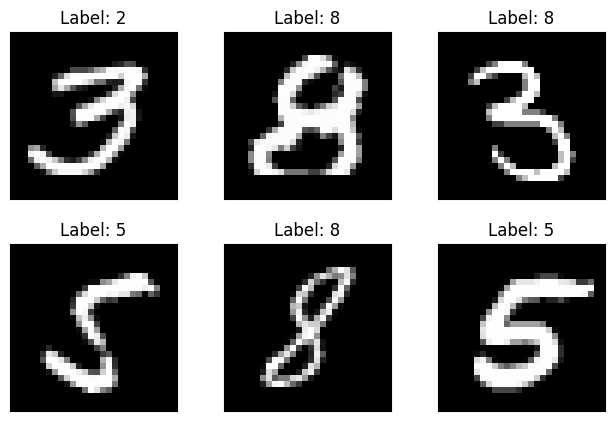

In [11]:
examples = enumerate(unlearning_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Model

In [12]:
# Hyperparameters
batch_size_train = 64
batch_size_test = 64
log_interval = 16
num_classes = 10
torch.backends.cudnn.enabled = True
criterion = F.nll_loss

In [13]:
# Training method
def train(model, epoch, loader, returnable=False):
    model.train()                         # ❶ 学習モードに切り替え (Dropout 等が有効)

    # ❷ 返り値用のリストを準備（必要なときだけ）
    if returnable:
        thracc  = []   # 「ラベル3だけ」の途中精度
        nacc    = []   # 「ラベル3以外」の途中精度
        batches = []   # Δθ を保存したバッチ番号

    # ❸ ミニバッチ学習ループ
    for batch_idx, (data, target) in enumerate(loader):

        optimizer.zero_grad()             # 勾配を 0 リセット
        output = model(data)              # 順伝播

        # ---- ここから Δθ ロギングの準備 -------------------
        steps = []                        # ★ミス：毎ループで初期化（返り値には最後の内容のみ残る）

        if 3 in target:                   # バッチに「3」が含まれるか判定
            before = {}                   # 学習前の重みをコピー
            for name in model.state_dict():
                if "weight" in name or "bias" in name:
                    before[name] = model.state_dict()[name].clone()

        # ---- 損失計算と重み更新 ----------------------------
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if 3 in target:
            batches.append(batch_idx)     # 何番目のバッチだったか記録
            after = {}                    # 更新後の重みをコピー
            for name in model.state_dict():
                if "weight" in name or "bias" in name:
                    after[name] = model.state_dict()[name].clone()

            # Δθ を辞書 step に格納
            step = {}
            for key in before:
                step[key] = after[key] - before[key]

            # Δθ をファイルに保存：steps/e<epoch>b<batch番号>.pkl
            with open(f"steps/e{epoch}b{batches[-1]:04}.pkl", "wb") as f:
                pickle.dump(step, f)

        # ---- ログ出力 --------------------------------------
        if batch_idx % log_interval == 0:
            print(f"\rEpoch: {epoch} [{batch_idx*len(data):6d}]\t"
                  f"Loss: {loss.item():.6f}", end="")

        # ---- 途中でテスト精度を測る -------------------------
        if returnable and batch_idx % 10 == 0:
            # 「3 だけ」の精度
            thracc.append(test(model, three_test_loader,
                               dname="Threes only", printable=False))
            # 「3 以外」の精度
            nacc.append(test(model, nonthree_test_loader,
                             dname="nonthree only", printable=False))
            model.train()                 # test() で eval に切り替わるので戻す

    # ---- 必要な情報を返す ---------------------------------
    if returnable:
        return thracc, nacc, batches, steps   # ★steps は最後のバッチ分のみ


In [14]:
# Testing method
def test(model, loader, dname="Test set", printable=True):
  model.eval()
  test_loss = 0
  total = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      output = model(data)
      total += target.size()[0]
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  if printable:
    print('{}: Mean loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        dname, test_loss, correct, total, 
        100. * correct / total
        ))
  return 1. * correct / total

# Original Training

In [15]:
trainingepochs = 10
forgetfulepochs = 10
naive_accuracy_three = []
naive_accuracy_nonthree = []

In [16]:
# load resnet 18 and change to fit problem dimensionality
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
resnet.fc = nn.Sequential(nn.Linear(512, num_classes), nn.LogSoftmax(dim=1))
optimizer = optim.Adam(resnet.parameters())

In [24]:
import os
os.makedirs('steps', exist_ok=True)
os.makedirs('resnet', exist_ok=True)

In [25]:
# --- 5エポックだけ新しいモデル(resnet)を学習し、途中指標とチェックポイントを残す ---

steps = []                                # Amnesiac用：Δθ（各バッチの重み差分）を全エポック分まとめるリスト
for epoch in range(1, trainingepochs + 1):
    starttime = time.process_time()       # 1エポックにかかったCPU時間を測るための開始時刻

    # -----------------------------------------------------------
    # ① 学習フェーズ
    # three_train_loader ＝ 「クラス3だけ100枚＋その他全クラス」の訓練セット
    # returnable=True なので train() は途中精度やΔθを返してくれる
    # 返ってくるもの：
    #   thracc        : 10バッチごとの「クラス3だけ」の精度 [%] のリスト
    #   nacc          : 同 「クラス3以外」の精度 [%] のリスト
    #   three_batches : Δθを保存したバッチ番号のリスト
    #   three_steps   : ΔθをPythonオブジェクトとして返したもの
    # -----------------------------------------------------------
    thracc, nacc, three_batches, three_steps = train(
        resnet, epoch, three_train_loader, returnable=True
    )

    # --- ② 途中精度を累積グラフ用リストに追記 --------------------
    naive_accuracy_three   += thracc     # クラス3精度
    naive_accuracy_nonthree += nacc      # クラス3以外精度

    # --- ③ Δθ をすべてまとめて保持（後で巻き戻しに使う） -------
    steps += three_steps

    # --- ④ 学習中に「クラス3を含むバッチ」が何個あったか表示 -----
    print(f"{three_batches} batches effected")

    # --- ⑤ テストフェーズ：3種類の精度を出力 ----------------------
    test(resnet, all_data_test_loader,  dname="All data")   # 全クラス
    test(resnet, three_test_loader,     dname="Threes  ")   # クラス3だけ
    test(resnet, nonthree_test_loader,  dname="Nonthree")   # クラス3以外

    # --- ⑥ エポックに要した時間を表示 -----------------------------
    print(f"Time taken: {time.process_time() - starttime:.1f}s")

    # -----------------------------------------------------------
    # ⑦ チェックポイントを保存（モデル重み＋オプティマイザ状態）
    #    例: resnet/selective_trained_e1.pt
    # -----------------------------------------------------------
    ckpt_path = f"resnet/selective_trained_e{epoch}.pt"
    torch.save({
        'model_state_dict':     resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, ckpt_path)

    # -----------------------------------------------------------
    # ⑧ 精度推移をテキストに保存（グラフ描画や再解析用）
    #    クラス3精度 → *_accuracy_three_e{epoch}.txt
    #    クラス3以外 → *_accuracy_nonthree_e{epoch}.txt
    #    カンマ区切りで追記せず“都度まるごと”書き直す
    # -----------------------------------------------------------
    path = f"resnet/selective_trained_accuracy_three_e{epoch}.txt"
    with open(path, 'w') as f:
        for val in naive_accuracy_three:
            f.write(f"{val},")            # 例: 0.78,0.80,0.82,...

    path = f"resnet/selective_trained_accuracy_nonthree_e{epoch}.txt"
    with open(path, 'w') as f:
        for val in naive_accuracy_nonthree:
            f.write(f"{val},")


Epoch: 1 [ 53248]	Loss: 0.090946[4, 14, 16, 22, 35, 37, 39, 45, 56, 66, 68, 82, 97, 105, 131, 146, 150, 156, 177, 178, 187, 190, 194, 205, 209, 210, 218, 222, 226, 229, 230, 237, 238, 251, 258, 262, 264, 274, 291, 313, 324, 335, 341, 350, 352, 375, 381, 383, 384, 389, 392, 402, 414, 419, 433, 443, 470, 494, 502, 511, 524, 571, 581, 582, 587, 588, 591, 600, 605, 623, 631, 632, 640, 653, 667, 674, 684, 692, 693, 695, 725, 731, 733, 740, 742, 751, 753, 760, 777, 791, 797, 811, 814, 830] batches effected
All data: Mean loss: 0.0028, Accuracy: 9513/10000 (95%)
Threes  : Mean loss: 0.0014, Accuracy: 744/1010 (74%)
Nonthree: Mean loss: 0.0013, Accuracy: 8769/8990 (98%)
Time taken: 11343.13200801
Epoch: 2 [ 53248]	Loss: 0.085618[0, 21, 22, 44, 58, 69, 100, 107, 112, 119, 120, 132, 158, 159, 164, 169, 191, 202, 203, 211, 224, 241, 250, 257, 265, 275, 276, 278, 288, 312, 321, 323, 327, 335, 344, 345, 350, 376, 379, 391, 397, 398, 400, 402, 406, 415, 417, 442, 453, 457, 461, 484, 503, 504, 506, 5

In [16]:
path = F"resnet/selective_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [17]:
path = F"resnet/selective_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [18]:
path = F"resnet/selective_trained_accuracy_three.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_three:
    f.write(f"{data},")

In [19]:
path = F"resnet/selective_trained_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in naive_accuracy_nonthree:
    f.write(f"{data},")

In [20]:
path = F"resnet/selective_trained.pt"
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [21]:
# ---------------- Amnesiac Unlearning 巻き戻しループ ----------------
# 学習時に保存しておいた Δθ ファイル（steps/e{エポック}b{バッチ}.pkl）を
# 1 つずつ読み込み、そのバッチがモデルに与えた更新量を “そっくり引き算”
# することで、該当データを “忘れさせる” 処理です。
# ------------------------------------------------------------------

for i in range(1, trainingepochs + 1):        # ① 学習に使った全エポックを順に
    for j in range(1600):                     # ② 1エポック≦1,600バッチまで走査
        path = f"steps/e{i}b{j:04}.pkl"       #    例: steps/e3b0057.pkl

        try:
            # ③ Δθ ファイルを開いてロード
            f = open(path, "rb")
            steps = pickle.load(f)            #    steps は dict{層名: Tensor(Δθ)}
            f.close()

            print(f"\rLoading {path}", end="") # 進捗メッセージ

            const = 1                         # ④ 巻き戻し係数 1=完全巻き戻し
            with torch.no_grad():             #    勾配計算を無効に
                state = resnet.state_dict()   #    現在の重み辞書を取得
                for param_tensor in state:    # ⑤ 全レイヤを走査
                    # "weight"/"bias" を含む名前だけ対象にする
                    if "weight" in param_tensor or "bias" in param_tensor:
                        # ★ 核心 ★
                        #   重み ← 重み − const × Δθ
                        state[param_tensor] = (
                            state[param_tensor] - const * steps[param_tensor]
                        )

            resnet.load_state_dict(state)     # ⑥ 更新後の重みをモデルに反映

        except FileNotFoundError:
            # ⑦ ファイルが無い＝そのバッチは保存していなかった → 何もしない
            pass


Loading steps/e10b0824.pkl

In [32]:
test(resnet, all_data_test_loader, dname="All data")
test(resnet, three_test_loader, dname="Threes  ")
test(resnet, nonthree_test_loader, dname="Nonthree")

All data: Mean loss: 0.0211, Accuracy: 8694/10000 (87%)
Threes  : Mean loss: 0.0196, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0017, Accuracy: 8694/8990 (97%)


tensor(0.967)

In [22]:
path = F"resnet/selective_post_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [23]:
path = F"resnet/selective_post_trained.pt"
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [17]:
selective_post_accuracy_three = []
selective_post_accuracy_nonthree =[]

In [18]:
# Train model for 10 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, nonthree_train_loader, returnable=False)
  thracc, nacc, _, _ = train(resnet, epoch, nonthree_train_loader, returnable=True)
  selective_post_accuracy_three += thracc
  selective_post_accuracy_nonthree += nacc
  test(resnet, all_data_test_loader, dname="All data")
  test(resnet, three_test_loader, dname="Threes  ")
  test(resnet, nonthree_test_loader, dname="Nonthree")
  path = F"resnet/selective-post-epoch-{epoch}.pt"
  torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)
  path = F"resnet/selective_post_accuracy_three_e{epoch}.txt"
  with open(path, 'w') as f:
    for data in naive_accuracy_three:
      f.write(f"{data},")
  path = F"resnet/selective_post_accuracy_nonthree_e{epoch}.txt"
  with open(path, 'w') as f:
    for data in naive_accuracy_nonthree:
      f.write(f"{data},")

Epoch: 11 [ 53248]	Loss: 0.090579All data: Mean loss: 0.0148, Accuracy: 8804/10000 (88%)
Threes  : Mean loss: 0.0141, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0009, Accuracy: 8804/8990 (98%)
Epoch: 12 [ 53248]	Loss: 0.031465All data: Mean loss: 0.0167, Accuracy: 8826/10000 (88%)
Threes  : Mean loss: 0.0160, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0008, Accuracy: 8826/8990 (98%)
Epoch: 13 [ 53248]	Loss: 0.122259All data: Mean loss: 0.0168, Accuracy: 8848/10000 (88%)
Threes  : Mean loss: 0.0162, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0007, Accuracy: 8848/8990 (98%)
Epoch: 14 [ 53248]	Loss: 0.012098All data: Mean loss: 0.0185, Accuracy: 8903/10000 (89%)
Threes  : Mean loss: 0.0183, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0005, Accuracy: 8903/8990 (99%)
Epoch: 15 [ 53248]	Loss: 0.003702All data: Mean loss: 0.0193, Accuracy: 8903/10000 (89%)
Threes  : Mean loss: 0.0189, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0005, Accuracy: 8903/8990 (99%)
Epoch: 16 [ 53248]	Loss: 

In [19]:
path = F"resnet/selective_post_accuracy_three.txt"
with open(path, 'w') as f:
  for data in selective_post_accuracy_three:
    f.write(f"{data},")

In [20]:
path = F"resnet/selective_post_accuracy_nonthree.txt"
with open(path, 'w') as f:
  for data in selective_post_accuracy_nonthree:
    f.write(f"{data},")